<img src='https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ-VfNtOyJbsaxu43Kztf_cv1mgBG6ZIQZEVw&usqp=CAU'>

# Procesamiento de Lenguage Natural

## Taller #7: Clasificación y Agrupación
`Fecha de entrega: Octubre 31, 2020. 

`Modo de entrega: Subir link de GitHub al aula virtual.`

In [136]:
import re
import json
import numpy as np
import json
import pandas as pd

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.offline import iplot

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving reviews_vidjew_es.csv to reviews_vidjew_es.csv
User uploaded file "reviews_vidjew_es.csv" with length 232489 bytes


In [24]:
# Cargar datos path = 'archivos/reviews_vidjew_es.csv'
data = pd.read_csv('reviews_vidjew_es.csv')
data.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0825565,product_es_0370490,reviewer_es_0174781,3,"Buen. Buena calidad, y buena presentación.",Contenta,es,jewelry
1,es_0227934,product_es_0354224,reviewer_es_0411613,3,"Un producto a perfecto, para salir de casa con...",Versatilidad,es,video_games
2,es_0468601,product_es_0665460,reviewer_es_0348315,1,No funciona con Nintendo Switch. No hay forma ...,Decepción absoluta,es,video_games
3,es_0814494,product_es_0692692,reviewer_es_0951508,5,"Recomendado, los utilizo para pc y no me dan n...",Auriculares Pecham ps4,es,video_games
4,es_0206329,product_es_0728826,reviewer_es_0493255,4,El cable funciona bien podria ser un poco mas ...,Perfecto,es,video_games


# Parte 1: Clasificación

### `[6 pts]` Punto 1: Dividir el conjunto de datos en entrenamiento y prueba

In [31]:
from sklearn.preprocessing import OrdinalEncoder
X = data[['review_body']]
encoder = OrdinalEncoder()
data['Categ'] = encoder.fit_transform(data[['product_category']])
y = data['Categ'].values

In [118]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=1234, test_size = 0.3, stratify=y)

###  `[6 pts]` Punto 2: Hacer pre-procesamiento del texto

In [119]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [120]:
X_train1 = tfidf_vect.fit_transform(X_train.review_body.values)
y_train = y_train

X_test1 = tfidf_vect.transform(X_test.review_body.values)
y_test = y_test

###  `[6 pts]` Punto 3: Entrenar el modelo
Puedes escoger el que quieras: Regresión Logística, Naive-Bayes, SVM, u otro.

In [68]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

###  `[6 pts]` Punto 4: Métricas de evaluación
Exactitud, precisión y sensibilidad

In [59]:
# Hacemos las predicciones para los datos de prueba (test)
y_nb =nb.predict(X_test)

In [71]:
metricas = [precision_score, recall_score, f1_score]

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_nb)

print("Métricas:\n")
for metrica in metricas:
    print(f"{metrica.__name__}: {metrica(y_test, y_nb):>2.4f}")  
print(f"accuracy_score: {accuracy_score(y_test, y_nb):>2.4f}")

Métricas:

precision_score: 0.9071
recall_score: 0.8523
f1_score: 0.8789
accuracy_score: 0.8833


###  `[BONUS: 3 pts]` Matriz de confusión

In [65]:
print(confusion_matrix(y_test, y_nb))

[[138  13]
 [ 22 127]]


###  `[BONUS: 1 pts]` Términos más importantes de cada categoría

In [75]:
vocab = {value:key for key, value in tfidf_vect.vocabulary_.items()}

los terminos más importante para la categoría 0 es decir, video juegos 

In [83]:
[(vocab[e[0]], round(e[1],2)) for e in zip(nb.coef_[0].argsort(),sorted(nb.coef_[0]))][-10:]

[('servir', -8.33),
 ('cristal', -8.33),
 ('cristales', -8.33),
 ('cromado', -8.33),
 ('llamé', -8.33),
 ('llegan', -8.33),
 ('penoso', -8.33),
 ('pendientes', -8.33),
 ('estrené', -8.33),
 ('cuarzo', -8.33)]

os terminos más importante para la categoría 1 es decir, joyerias

In [99]:
[(vocab[e[0]], round(e[1],2)) for e in zip(nb.coef_[0].argsort(),sorted(nb.coef_[0]))][:10]

[('hijo', -6.52),
 ('buen', -6.43),
 ('jugar', -6.38),
 ('mando', -6.33),
 ('precio', -6.29),
 ('si', -6.28),
 ('perfecto', -6.14),
 ('producto', -6.13),
 ('bien', -5.85),
 ('juego', -5.73)]

# Parte 2: Agrupación

###  `[6 pts]` Punto 1: Hacer pre-procesamiento del texto

In [115]:
stopwords_sp = stopwords.words('spanish')

def pre_procesado(texto):
    texto = texto.lower()
    texto = re.sub(r"[\W\d_]+", " ", texto)
    texto = " ".join([palabra for palabra in texto.split() if palabra not in stopwords_sp])
    return texto

tfidf_vect = TfidfVectorizer(preprocessor=pre_procesado)

In [122]:
X_train_2 = pd.DataFrame(X_train1.toarray(), columns=tfidf_vect.get_feature_names())
y_train = y_train

X_test = tfidf_vect.transform(X_test.review_body.values)
y_test = y_test

###  `[6 pts]` Punto 2: Método del codo para determinar $K$

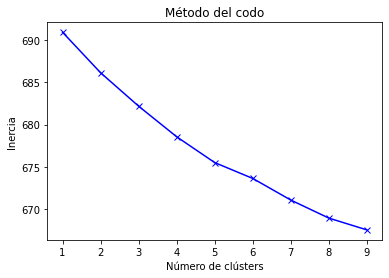

In [123]:
ks = []
kinertia = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=1234).fit(X_train_2)
    ks.append(k)
    kinertia.append(kmeans.inertia_)
    
plt.xlabel("Número de clústers"); 
plt.ylabel("Inercia");
plt.title('Método del codo')
plt.plot(ks,kinertia, 'bx-');

No es muy claro el K optimo, se selecciona 5 como k-optimo

###  `[6 pts]` Punto 3: Entrenar modelo con el $K$ escogido

In [146]:
k_op = 5
model_kmeans = KMeans(n_clusters=k_op, random_state=2805)
model_kmeans.fit(X_train_2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=2805, tol=0.0001, verbose=0)

In [ ]:
X_train.loc[:,'cluster'] = model_kmeans.labels_

In [148]:
X_train.tail(5)

,review_body,cluster
1,"Un producto a perfecto, para salir de casa con...",3
194,"Por el precio está bien, pero son de muy mala ...",2
321,Se me agrietó la goma original del joystick y ...,4
504,Muy útil y manejable,4
468,"No hace apenas ruido, y por el precio que tien...",0


###  `[BONUS: 3 pts]` Visualización usando PCA

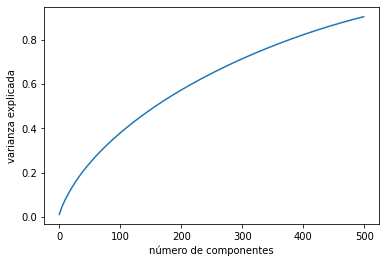

In [149]:
pca = PCA(n_components=500)
pca.fit_transform(X_train_2)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('número de componentes')
plt.ylabel('varianza explicada')
plt.show()

In [150]:
pca = PCA(n_components=2)

result = pca.fit_transform(X_train_2)
result = pd.DataFrame(result)
result.columns = ['X', 'Y']
result['cluster'] = X_train.cluster.values
result['texto'] = X_train.review_body.apply(lambda val: val[:100])

trace = go.Scatter(x=result['X'].values,
                   y=result['Y'].values,
                   text=result['texto'].values,
                   mode='markers',
                   marker=dict(color=result['cluster'].values)) 

layout = go.Layout(title="PCA")

fig = go.Figure(data=trace, layout=layout)
iplot(fig)

# Parte 3: Comparación

### `[6 pts]` Punto 1: Hacer predicción para estas dos frases de los dos modelos

In [ ]:
test = ["Necesitas el juego inicial para eso", "Preciosos estos aretes, buena calidad"]
# transformar con tfidf usado para clasificación
# transformar con tfidf usado para agrupación

# resultado para clasificación
# resultado para agrupación

['video_games' 'jewelry']
[1 2]


### `[2 pts]` Punto 2: Preguntas

- ¿A cuál modelo le fue mejor? 
- ¿Cuál modelo se demoró más en entrenar? 
- Según los resultados del $K$-Means, ¿cuál es la estructura latente de los datos?
- ¿Alguna otra observación?